# Using Simons CMAP to decompose the SeaFlow time series and estimate diel variation over cruises

In [21]:
import os
import pandas as pd
import numpy as np
import plotnine as p9
import pycmap
from scipy import stats
import re
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from diel_tools import *
from tsd_functions import *
import warnings
import seaborn as sns
from dateutil.parser import parse
import datetime
# suppress warnings, i know they're there but i don't care!
warnings.simplefilter('ignore')

## SeaFlow Data Retrieval through CMAP

In [ ]:
## call CMAP to get seaflow datasets
key =!tail ".cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[1]) 

In [26]:
# grab seaflow data from api, grouped on an hourly basis (thanks diana!)
qry="""SELECT DATEPART(YEAR, time) Year
,DATEPART(MONTH, time) Month
,DATEPART(DAY, time) Day
,DATEPART(HOUR, time) Hour
,avg(lat)lat
--,avg(CASE WHEN (cruise = 'Tokyo_4' AND DAY(time)=31 AND DATEPART(HOUR,time)=13 and lon <0) OR
--    (cruise = 'Tokyo_3' AND DAY(time)=27 AND DATEPART(HOUR,time)=2 and lon <0) OR
--    (cruise = 'SR1917' AND DAY(time)=16 AND DATEPART(HOUR,time)=0 and lon <0) 
--    THEN lon+360 ELSE lon END) lon
,avg(CASE WHEN lon <0 THEN lon+360 ELSE lon END) lon
,avg(depth)depth
,cruise
,avg(ISNULL(abundance_prochloro,0))abundance_prochloro
,avg(ISNULL(abundance_synecho,0))abundance_synecho
,avg(ISNULL(abundance_picoeuk,0))abundance_picoeuk
,avg(ISNULL(abundance_croco,0))abundance_croco
,avg(ISNULL(diam_prochloro,0))diam_prochloro
,avg(ISNULL(diam_synecho,0))diam_synecho
,avg(ISNULL(diam_picoeuk,0))diam_picoeuk
,avg(ISNULL(diam_croco,0))diam_croco
,avg(ISNULL(Qc_prochloro,0))Qc_prochloro
,avg(ISNULL(Qc_synecho,0))Qc_synecho
,avg(ISNULL(Qc_picoeuk,0))Qc_picoeuk
,avg(ISNULL(Qc_croco,0))Qc_croco
,avg(ISNULL(biomass_prochloro,0))biomass_prochloro
,avg(ISNULL(biomass_synecho,0))biomass_synecho
,avg(ISNULL(biomass_picoeuk,0))biomass_picoeuk
,avg(ISNULL(biomass_croco,0))biomass_croco
  FROM tblSeaFlow_v1_5
WHERE time <> '2019-11-16 00:45:05.000' -- Removing single point from cruise SR1917 with lon at -144
GROUP BY cruise,  
DATEPART(YEAR, time),
DATEPART(MONTH, time),
DATEPART(DAY, time),
DATEPART(HOUR, time)
ORDER BY cruise, year, month, day, hour"""
seaflow_hourly = api.query(qry)

## Colocalization for PAR and temp data

In [27]:
# reararange time columns
timecols = ['Year', 'Month', 'Day', 'Hour']
seaflow_hourly['time'] = pd.to_datetime(seaflow_hourly[timecols]).dt.strftime('%Y-%m-%d-%H:00:00')
seaflow_hourly.drop(columns=timecols, inplace=True)
# adjust longitude for CMAP
seaflow_hourly['lon']=np.where(seaflow_hourly['lon'] > 180, 
                               seaflow_hourly['lon'] - 360, 
                               seaflow_hourly['lon'])

In [5]:
# colocalize on PAR and temp
# read in seaflow dataset (surface level- 5m- continuous samples across 50 cruises)
#seaflow = api.get_dataset('tblSeaFlow_v1_5') # this is the new seaflow dataset versions

# colocalize to get daily par and temperature
daily_targets = {
    'tblModis_PAR' : {
        'variables': ['PAR'],
        'tolerances': [1, 0.25, 0.25, 5]
    },
    "tblSST_AVHRR_OI_NRT": {
        "variables": ["sst"],
        "tolerances": [1, 0.25, 0.25, 5]
    },
}
# # let's merge on daily data with since par and temperature are daily averages
# daily = seaflow_hourly.groupby([pd.Grouper(key='time',freq='24H'), 'cruise']).mean().reset_index()
# # switch longitudes back to international date format
# daily['lon']=np.where(daily['lon'] > 180, daily['lon'] - 360, daily['lon'])
# # set time type for colocalization
# daily['time'] = daily.time.dt.strftime('%Y-%m-%d')
#colocalize on daily seaflow data to run faster
coloc_samp = pycmap.Sample(
              source=seaflow_hourly, 
              targets=daily_targets, 
              replaceWithMonthlyClimatolog=True
             )

Gathering metadata .... 
Sampling starts.
10608 / 10612 ... sampling tblSST_AVHRR_OI_NRT10605 / 10612 ... sampling tblSST_AVHRR_OI_NRT... sampling tblModis_PARg tblSST_AVHRR_OI_NRTsampling tblSST_AVHRR_OI_NRTdis_PAR9647 / 10612 ... sampling tblModis_PAR9661 / 10612 ... sampling tblModis_PAR9669 / 10612 ... sampling tblModis_PAR9725 / 10612 ... sampling tblModis_PAR9726 / 10612 ... sampling tblModis_PAR9722 / 10612 ... sampling tblSST_AVHRR_OI_NRT9739 / 10612 ... sampling tblSST_AVHRR_OI_NRT9737 / 10612 ... sampling tblSST_AVHRR_OI_NRT9742 / 10612 ... sampling tblSST_AVHRR_OI_NRT9746 / 10612 ... sampling tblSST_AVHRR_OI_NRT9774 / 10612 ... sampling tblModis_PAR9788 / 10612 ... sampling tblModis_PAR9797 / 10612 ... sampling tblModis_PAR9794 / 10612 ... sampling tblSST_AVHRR_OI_NRT9843 / 10612 ... sampling tblSST_AVHRR_OI_NRT9891 / 10612 ... sampling tblModis_PAR9908 / 10612 ... sampling tblSST_AVHRR_OI_NRT9937 / 10612 ... sampling tblSST_AVHRR_OI_NRT9959 / 10612 ... sampling tblModis_PAR

In [7]:
# save the original colocalized object just in case of disasters
hourly_samp = coloc_samp.copy()
# fix time to be in the right format
hourly_samp['time']=pd.DatetimeIndex(hourly_samp['time']).tz_convert('UTC')
# fix some column names to be more readable
hourly_samp.rename(columns={'CMAP_PAR_tblModis_PAR':'par','CMAP_sst_tblSST_AVHRR_OI_NRT':'temp'},inplace=True)

## Cleaning to get the data in the right shape and format

In [13]:
# melt data from wide to long
hourly_samp['id'] = hourly_samp.index
long_sf = pd.wide_to_long(hourly_samp, stubnames=['abundance', 'diam', 'Qc', 'biomass',],
                sep='_',
                i='id', 
                j='pop',
               suffix='\w+').reset_index().drop(columns=['id']).rename(columns={'diam':'diam_med'})

In [14]:
long_sf

pop       temp         lon   cruise        par  \
0      prochloro  14.923327  238.153410   CN11ID  36.523118   
1      prochloro  14.923327  238.153500   CN11ID  36.523118   
2      prochloro  14.923327  238.149958   CN11ID  36.523118   
3      prochloro  15.009994  237.981653   CN11ID  35.897106   
4      prochloro  15.009994  237.976731   CN11ID  35.897106   
...          ...        ...         ...      ...        ...   
42443      croco  14.651105  240.913540  Tokyo_4  23.874292   
42444      croco  14.778327  241.092645  Tokyo_4  22.901498   
42445      croco  14.985827  241.275630  Tokyo_4  22.123498   
42446      croco  15.113327  241.456045  Tokyo_4  21.327405   
42447      croco  15.113327  241.548300  Tokyo_4  20.696850   

                           time        lat  depth  abundance  diam_med  \
0     2011-09-30 18:00:00+00:00  36.796929      5  51.526562  0.570233   
1     2011-09-30 19:00:00+00:00  36.796866      5  51.485916  0.560403   
2     2011-09-30 20:00:00+00:00  36.796407      5  36.989577  0.571116   
3     2011-09-30 21:00:00+00:00  36.735486      5  55.592932  0.527711   
4     2011-09-30 22:00:00+00:00  36.734031      5  44.568543  0.535876   
...                         ...        ...    ...        ...       ...   
42443 2012-02-06 17:00:00+00:00  33.930475      5   0.004215  0.247348   
42444 2012-02-06 18:00:00+00:00  33.846695      5   0.000000  0.000000   
42445 2012-02-06 19:00:00+00:00  33.760930      5   0.008353  0.621832   
42446 2012-02-06 20:00:00+00:00  33.674310      5   0.000000  0.000000   
42447 2012-02-06 21:00:00+00:00  33.630700      5   0.000000  0.000000   

             Qc   biomass  
0      0.035131  1.803722  
1      0.033601  1.724871  
2      0.035285  1.297305  
3      0.028768  1.585437  
4      0.029960  1.322327  
...         ...       ...  
42443  0.462744  0.039008  
42444  0.000000  0.000000  
42445  1.675340  0.139969  
42446  0.000000  0.000000  
42447  0.000000  0.000000  

[42448 rows x 12 columns]

## Where did SeaFlow go?
#### Mostly the N. Pacific!

In [15]:
# switch longitudes back
hourly_samp['lon']=np.where(hourly_samp['lon'] < 0, hourly_samp['lon'] + 360, hourly_samp['lon'])
daily = hourly_samp.groupby([pd.Grouper(key='time',freq='24H'), 'cruise']).mean().reset_index()
px.scatter_geo(daily, lat='lat',lon='lon',color='cruise', title='Daily SeaFlow Cruise Tracks')

## What does the distribution of SeaFlow estimated diameter look like for different populations?

In [17]:
hist_data = [hourly_samp['diam_prochloro'], hourly_samp['diam_synecho'], 
             hourly_samp['diam_picoeuk']]
group_labels = ['pro','syn','picoeuk'] # name of the dataset

# create plot
fig = ff.create_distplot(hist_data, group_labels, bin_size=.01,show_rug=False, histnorm='probability')
# add x/ylabels and title
fig.update_layout(
    title="Pro and Syn Probability Distributions",
    xaxis_title="Median Diameter (µm)",
    yaxis_title="Probability",
    legend_title="Population"
)
fig.show()

## Now we'll run a time series decomposition (TSD) model to deconvolve our cruise time series into different components!
### Here, the run_TSD function will linearly interpolate the values before running the data on a rolling hourly basis for 3 day chunks
This model is a multiplicative function, which can be written as: 
$$Y_t = T_t * S_t * R_t $$
which can also be written as:
$$log(Y_t) = log(T_t) + log(S_t) + log(R_t) $$

$S_t$ can be thought of the change in size from the diel cycle in each day. By modeling the change in size on a 24 hour cycle, we can start to see diel variation change throughout the cruise. 

### Example 1: Run the Gradients cruises through the TSD model

In [164]:
def find_night(df):
    # drop annoying columns
    if 'index' in df:
        df.drop(columns=['index'], inplace=True)
    df = df[df['lat'].notnull()].reset_index()#.drop(columns=['index'])
    # offset by 1 day
    df['time_day'] = df['time'].dt.round('1d') #- pd.DateOffset(1)
    df['night'] = 'nan'

    # loooooop thru whee! (using sunrise/sunset is better than dawn/dusk- why?)
    for index, row in df.iterrows():
        # is it night time?
        obs = Observer(row['lat'], row['lon'], 0)
        sr = sunrise(obs, date = row['time_day'])
        ss = sunset(obs, date = row['time_day'])
        # round to nearest hour
        night_time = [hour_rounder(pd.to_datetime(x)) for x in (sr, ss)]
        # say if time is at sunset
        if row['time'] == night_time[0]:
            df.loc[index, 'night'] = 'sunrise'
        # sunrise check
        elif row['time'] == night_time[1]:
            df.loc[index, 'night'] = 'sunset'
        # day check
        elif is_time_between(night_time[0], night_time[1], row['time']):
            # catch edge case where astral fails to find sunrise
            if (0 < index < len(df)):
                # change to sunrise if the row directly before is night
                if (df.loc[index-1, 'night']=='night'):
                    df.loc[index-1, 'night']='sunrise'
                    df.loc[index,'night']='day'
                else:
                    df.loc[index, 'night'] = 'day'
            else:
                df.loc[index, 'night'] = 'day'
        # night check
        else:
            # catch edge case where astral fails to find sunset
            if (0 < index < len(df)):
                # must be run after index check or will fail
                if (df.loc[index-1, 'night']=='day'):
                    # change previous row to sunrise if before is day
                    df.loc[index-1, 'night']='sunset'
                    # change present row
                    df.loc[index, 'night']='night'
                else:
                    df.loc[index, 'night'] = 'night'
            else:
                df.loc[index, 'night'] = 'night'
    return(df)

def calc_daily_vars(diel_df, col, func='sum'):
    # find times between sunrise and sunset each day to calculate par from each full day
    check_times = ['sunrise', 'sunset']
    dd = diel_df[diel_df['night'].isin(check_times)]
    # keep track of daily calculated par
    par_vals = []
    days = []
    # implement row iterator to check next row
    row_iterator = dd.iterrows()
    _, last_row = next(row_iterator)
    # loop through to find indices with day
    for i, row in row_iterator:
        # if first element is sunset, then skip row
        if (last_row['night']=='sunset'):
            last_row = row
            continue
        # check if at the end
        elif (last_row['night']=='sunrise'):
            # starting at sunrise, save index
            day_inds = np.arange(last_row.name, row.name+1)
            # get par values from day indices
            if func=='sum':
                daily_par = {row['time']:np.sum(diel_df.iloc[day_inds]['par'])}
            elif func=='mean':
                daily_par = {row['time']:np.mean(diel_df.iloc[day_inds]['par'])}
            par_vals.append(daily_par)
            days.append(day_inds)
            last_row = row
        # skip if sunset
        else:
            last_row = row
            continue

    # make df to calculate total par per day
    sunset = [list(n.keys())[0] for n in par_vals]
    par_sum = [list(n.values())[0] for n in par_vals]
    daily_par = pd.DataFrame()
    # time is at sunset, end of the day
    daily_par['time'] = sunset
    daily_par['par_new']= par_sum
    # return daily par values and day indices
    return(daily_par, days)

def plot_diel_cycle(seasonal_df, trend_df, diel_df, cruise_name):
    # make figure object
    fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False, figsize=(16,10))
    plt.rcParams.update({'font.size': 15})
    # make secondary axes
    ax0 = axs[0].twinx()
    ax1 = axs[1].twinx()
    
    # plot 1 subplot
    pro_hourly = seasonal_df.loc[seasonal_df['pop']=='prochloro']
    pro_trend = trend_df.loc[trend_df['pop']=='prochloro']
    # set variables
    x = pro_hourly['time']
    x1 = pro_trend['time']
    y1 = pro_trend['trend mean']
    y = pro_hourly['seasonal mean']
    error = pro_hourly['seasonal std']
    error1 = pro_trend['trend std']

    # plot seasonal
    l1=axs[0].plot(x, y, label='Seasonal')
    # plot uncertainity (std)
    axs[0].fill_between(x, y-error, y+error, alpha=0.2)
    # plot trend in secondary axis (std = 0 bc trend calculated by CMA)
    l2=ax0.plot(x1, y1, linestyle='--', label='Trend')
    ax0.fill_between(x1, y1-error1, y1+error1, alpha=0.2)

    # add legend
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    axs[0].legend(lns, labs, loc=0)

    # plot 2 subplot
    syn_hourly = seasonal_df.loc[seasonal_df['pop']=='synecho']
    syn_trend = trend_df.loc[trend_df['pop']=='synecho']
    x = syn_hourly['time']
    x1 = syn_trend['time']
    y1 = syn_trend['trend mean']
    y = syn_hourly['seasonal mean'] 
    error = syn_hourly['seasonal std']
    error1 = syn_trend['trend std']
    l1 = axs[1].plot(x, y, color='green', label='Seasonal')
    axs[1].fill_between(x, y-error, y+error, color = 'green', alpha=0.2)
    # plot trend in secondary axis axis
    l2=ax1.plot(x1, y1, linestyle='--', color='green', label='Trend')
    ax1.fill_between(x1, y1-error1, y1+error1, alpha=0.2)
    # add legend
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    axs[1].legend(lns, labs, loc=0)

    # add night bars
    # plot par edges as lines for both subplots
    ax0.fill_between(diel_df['time'], 0, 1, where=diel_df['night'] != 'day',
                    color='gray', alpha=0.3, transform=ax0.get_xaxis_transform())
    ax1.fill_between(diel_df['time'], 0, 1, where=diel_df['night'] != 'day',
                    color='gray', alpha=0.3, transform=ax1.get_xaxis_transform())
    
    # plot 3 subplot (lat/par)
    # plot latitude
    ln1=axs[2].plot(diel_df['time'], diel_df['lat'], c='red', alpha=0.5, label='Latitude')
    # calculate par from diel df
    par_df, day_inds = calc_daily_vars(diel_df, col='par', func='mean')
    # plot PAR on secodnary axis
    ax2 = axs[2].twinx()
    ln2=ax2.plot(par_df['time'], par_df['par_new'], c='orange', alpha=0.5, marker='.', label='Total Daily Par')

    ###### move this into panels to the next column from data in the future (deprecated for now) #########
    # pro_bio = np.log(get_trend_only(diel_df, 
    #               pop='prochloro',
    #               col='biomass'))
    # syn_bio = np.log(get_trend_only(syn_diel, 
    #               pop='synecho',
    #               col='biomass'))
    # ln3=ax2.plot(diel_df['time'],pro_bio.values, alpha=0.5, label='Pro', linestyle=':')
    # ln4=ax2.plot(syn_diel['time'],syn_bio.values, c='g', alpha=0.5, label='Syn', linestyle=':')
    # add legend for panel
    lns = ln1+ln2#+ln3+ln4
    labs = [l.get_label() for l in lns]
    axs[2].legend(lns, labs)#, loc='center left', bbox_to_anchor=(1.05, 0.5))
    

    # add x and y labels
    axs[0].set_ylabel('Pro Diel', c='blue')
    ax0.set_ylabel('Pro Diameter', c='blue')
    axs[1].set_ylabel('Syn Diel', c='green')
    ax1.set_ylabel('Syn Diameter', c='green')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Latitude', c='red')
    ax2.set_ylabel('PAR', c='orange')
    plt.suptitle(f'{cruise_name} Hourly Averaged Diel Cycle')
    # # fix y range- diel
    # axs[0].set_ylim([0.85, 1.25])
    # axs[1].set_ylim([0.85, 1.25])
    # fix for diam- pro
    ax0.set_ylim([0, 0.1])
    # syn
    ax1.set_ylim([0, 1])
    # aesthetics
    plt.tight_layout()
    # return figure
    return(fig)

# function to run the TSD model and output results
# input: df = input dataframe for cruise, show_figs = show plots or not (default False)
def run_TSD(df, cruise_name, show_tsd_figs=False,):
    # sort df by time first
    
    # run interpolation helper function (linear)
    pro_res = interp_by_time(df, 'prochloro')
    syn_res = interp_by_time(df, 'synecho')
    # run find night to get day/night and sunrise/sunset hours
    diel_df = find_night(pd.concat([pro_res, 
                                    syn_res])).drop_duplicates(subset=['time', 
                                                                       'lat', 
                                                                       'lon']).sort_values(by='time').reset_index()
    # run seasonal decompose on interpolated df
    result_pro = seasonal_decompose(pro_res['diam_med'], model='multiplicative', period=24)
    result_syn = seasonal_decompose(syn_res['diam_med'], model='multiplicative', period=24)
    # show results of initial TSD model if True
    if show_tsd_figs:
        fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
        plotseasonal(result_pro, axes[:,0], pop=f'{cruise_name} Pro', lat=pro_res['lat'])
        plotseasonal(result_syn, axes[:,1], pop=f'{cruise_name} Syn', lat=syn_res['lat'])
        plt.tight_layout()
        plt.show()
    # run model using rolling hourly data on 3 day windows
    pro_seasonal, pro_trend, pro_resid = rolling_tsd(pro_res, 'diam_med')
    pro_seasonal['pop'] = 'prochloro'
    pro_trend['pop'] = 'prochloro'
    pro_resid['pop'] = 'prochloro'
    syn_seasonal, syn_trend, syn_resid = rolling_tsd(syn_res, 'diam_med')
    syn_seasonal['pop'] = 'synecho'
    syn_trend['pop'] = 'synecho'
    syn_resid['pop'] = 'synecho'
    # concat into 1 combined df
    seas_all = pd.concat([pro_seasonal, syn_seasonal])
    trend_all = pd.concat([pro_trend, syn_trend])
    resid_all = pd.concat([pro_resid, syn_resid])
    # summarized dfs 
    seas_hourly = summarize_by_pop_time(seas_all, 'seasonal')
    trend_hourly = summarize_by_pop_time(trend_all, 'trend')
    resid_hourly = summarize_by_pop_time(resid_all, 'resid')
    # generate plot
    final = plot_diel_cycle(seas_hourly, trend_hourly, diel_df, cruise_name)
    return(seas_all, trend_all, resid_all, diel_df, final)

In [74]:
long_sf = long_sf[long_sf['diam_med']>0]

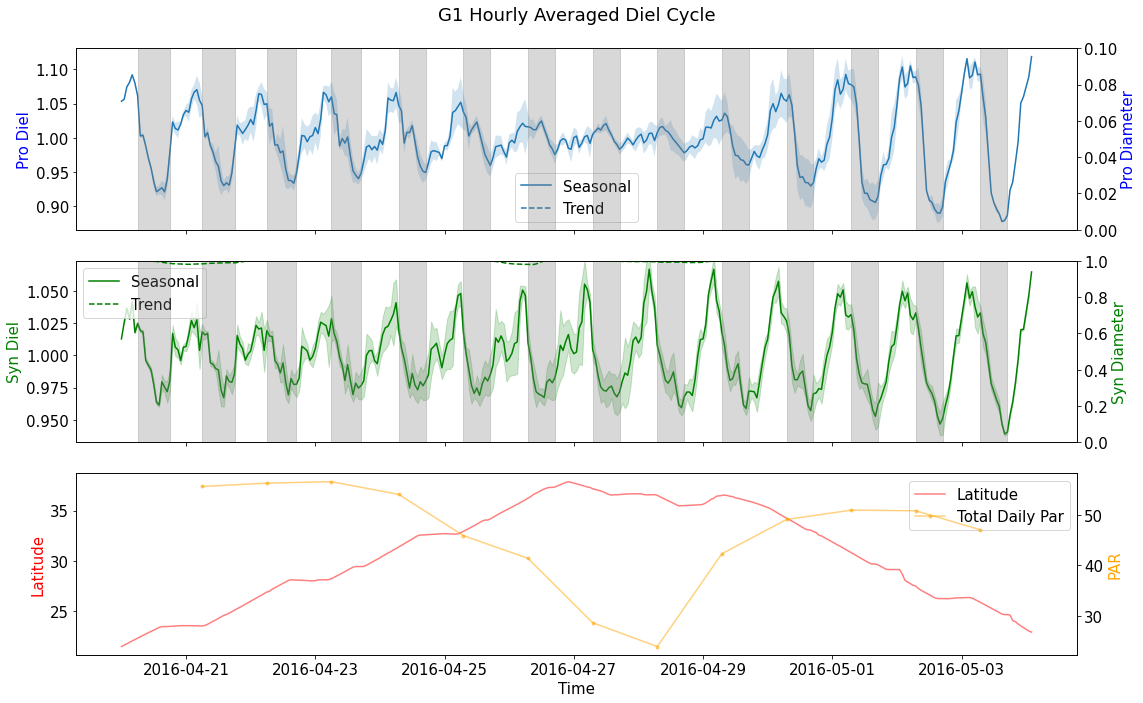

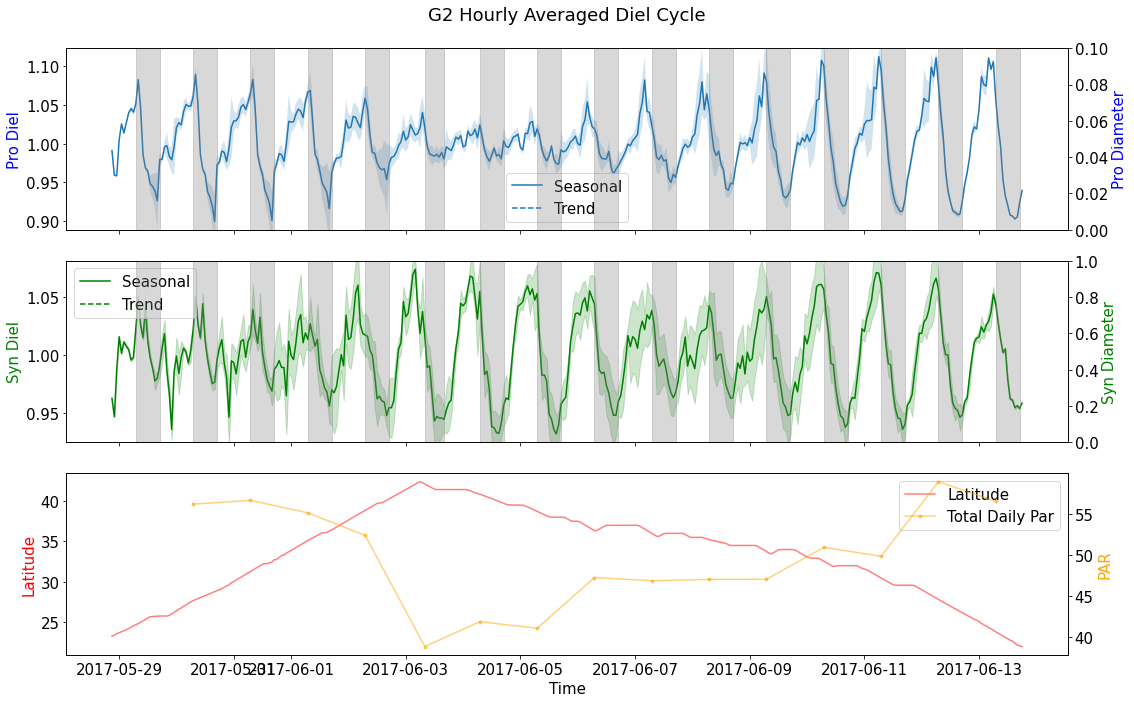

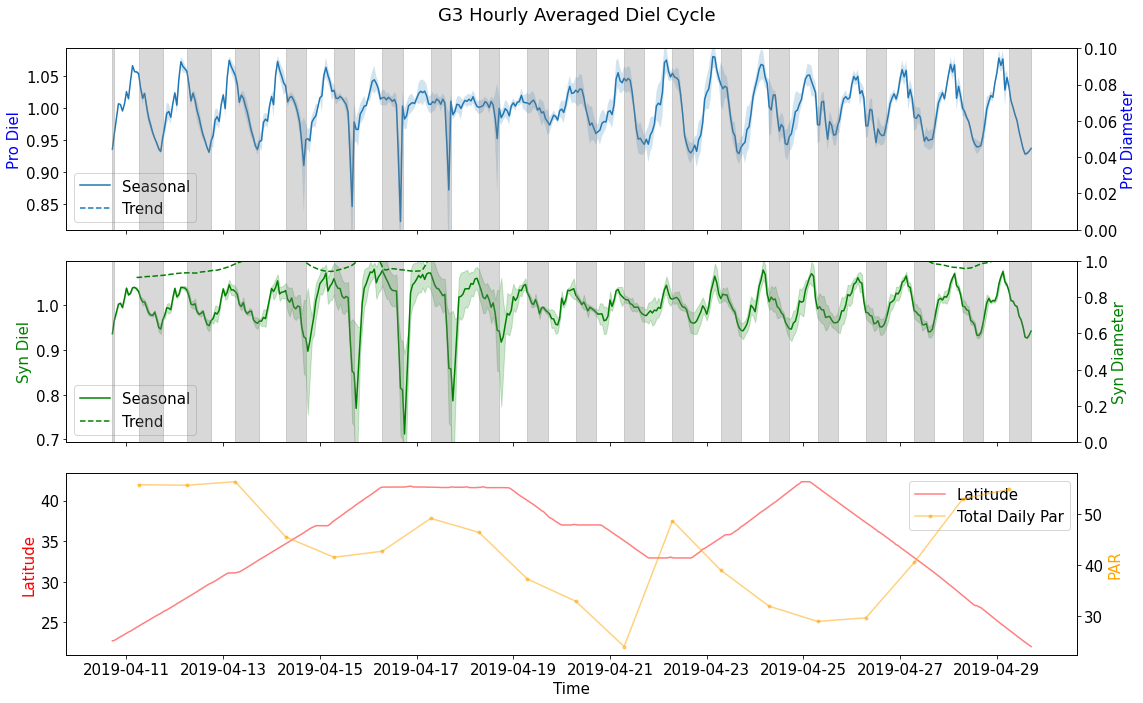

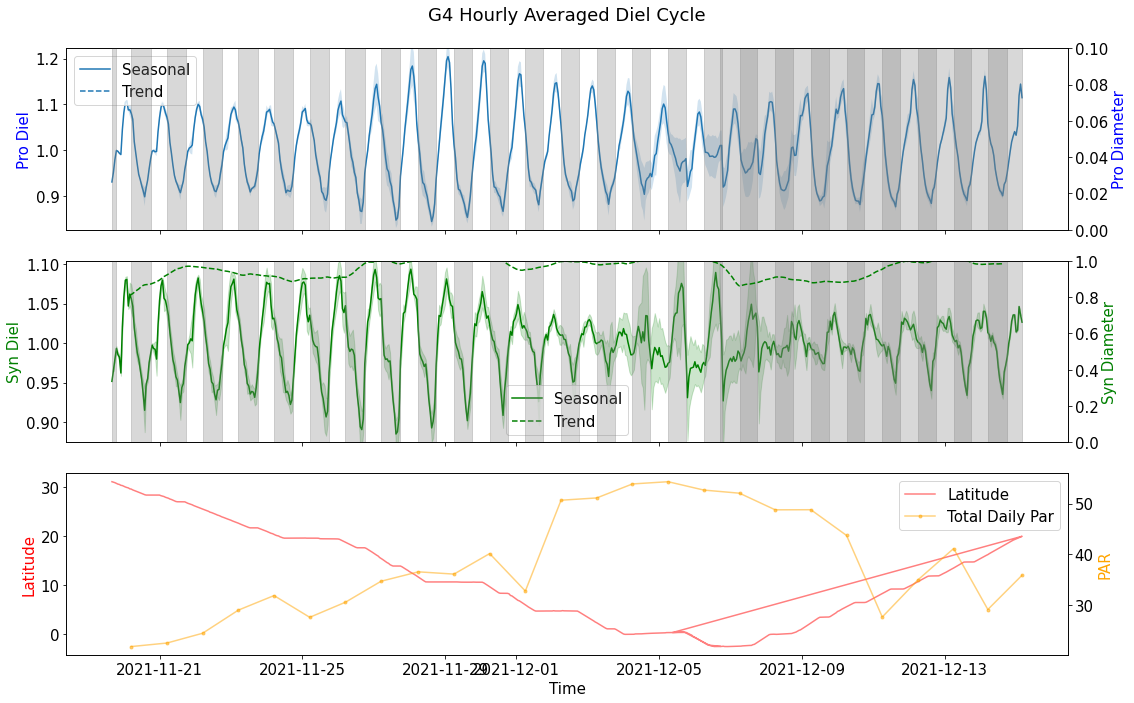

In [75]:
# pull the gradients cruises from the cruise list
gradients = ['KOK1606','MGL1704','KM1906','TN397']
cruise_list = [long_sf.loc[long_sf['cruise']==n] for n in gradients]
names = ['G1','G2','G3','G4']

for cruise, name in zip(cruise_list, names):
    seasonal, trend, resid, diel, plot0 = run_TSD(cruise, name, False)
#    seasonal, trend, resid, diel, plot0 = component_strength(resid, seasonal, trend, name)    

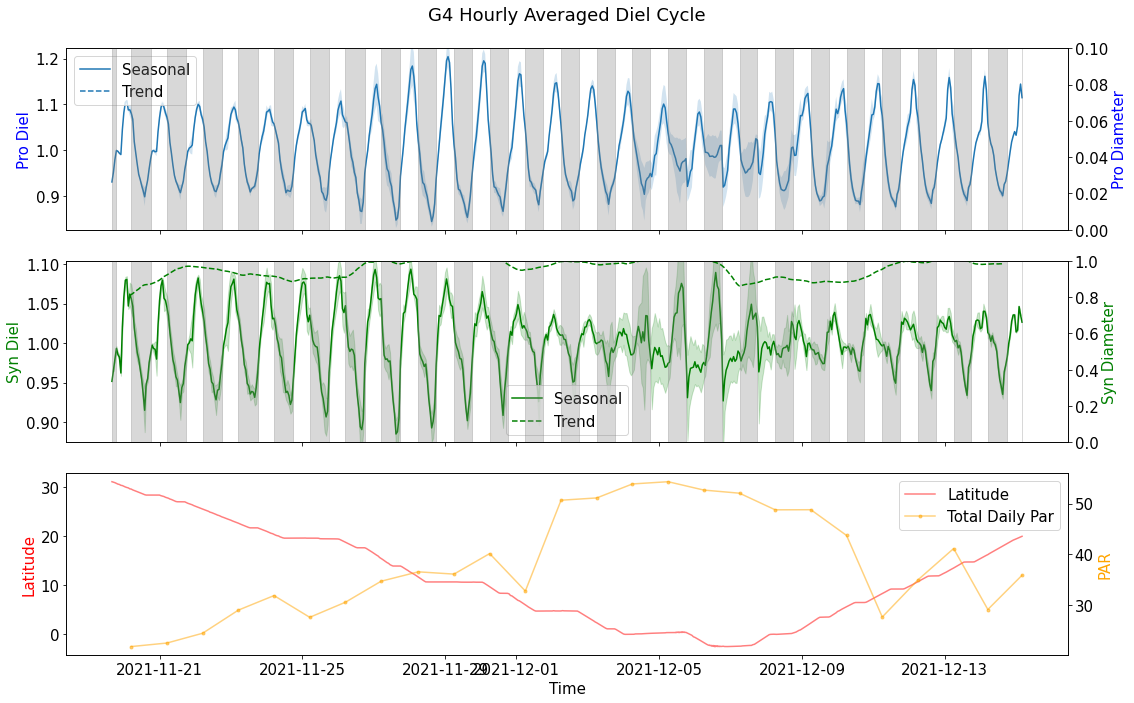

In [165]:
g4_sort = cruise_list[3].sort_values(by='time')
seasonal, trend, resid, diel, plot0 = run_TSD(g4_sort, names[3], False)

In [161]:
cruise_list[3].drop_duplicates(subset=['time','lat','lon']).sort_values(by='time').reset_index()

index        pop       temp         lon cruise        par  \
0     9310  prochloro  17.459165  240.237825  TN397  17.745053   
1     9311  prochloro  17.501663  240.049345  TN397  19.197276   
2     9312  prochloro  17.501663  239.895645  TN397  19.829627   
3     9313  prochloro  17.652495  239.631321  TN397  20.798331   
4     9314  prochloro  17.542495  239.396834  TN397  21.682165   
..     ...        ...        ...         ...    ...        ...   
574   9884  prochloro  25.864993  203.477359  TN397  37.680295   
575   9885  prochloro  25.864993  203.386519  TN397  37.067295   
576   9886  prochloro  25.739157  203.288400  TN397  36.355795   
577   9887  prochloro  25.634995  203.184721  TN397  36.415499   
578   9888  prochloro  25.544997  203.079544  TN397  36.661814   

                         time        lat  depth   abundance  diam_med  \
0   2021-11-19 16:00:00+00:00  31.162109      5   44.131024  0.464391   
1   2021-11-19 17:00:00+00:00  31.054478      5   54.809885  0.489422   
2   2021-11-19 18:00:00+00:00  30.966011      5   68.536987  0.494314   
3   2021-11-19 19:00:00+00:00  30.807882      5   56.358902  0.474448   
4   2021-11-19 20:00:00+00:00  30.670862      5   51.622007  0.507641   
..                        ...        ...    ...         ...       ...   
574 2021-12-15 00:00:00+00:00  19.491711      5  225.259228  0.583302   
575 2021-12-15 01:00:00+00:00  19.614395      5  216.271205  0.577059   
576 2021-12-15 02:00:00+00:00  19.741617      5  248.373865  0.601405   
577 2021-12-15 03:00:00+00:00  19.875660      5  266.401575  0.626576   
578 2021-12-15 04:00:00+00:00  20.019170      5  251.780865  0.606336   

           Qc    biomass  
0    0.020685   0.912545  
1    0.023691   1.293788  
2    0.024297   1.665543  
3    0.021858   1.228747  
4    0.026025   1.340745  
..        ...        ...  
574  0.037267   8.440751  
575  0.036220   7.838528  
576  0.040343  10.052402  
577  0.044792  11.935433  
578  0.041155  10.363841  

[579 rows x 13 columns]

In [153]:
diel.loc[diel['night']=='night'].reset_index()[280:]

level_0  index                      time       temp         lon  \
280      595    595 2021-12-14 11:00:00+00:00  25.368332  205.144316   
281      596    596 2021-12-14 12:00:00+00:00  25.364163  205.017918   
282      597    597 2021-12-14 13:00:00+00:00  25.339165  204.890077   
283      598    598 2021-12-14 14:00:00+00:00  25.376662  204.753300   
284      599    599 2021-12-14 15:00:00+00:00  25.365827  204.630187   
285      600    600 2021-12-14 16:00:00+00:00  25.422490  204.475386   
286      601    601 2021-12-14 17:00:00+00:00  25.510825  204.338962   
287      613    990 2021-12-05 09:00:00+00:00  24.638742  220.241260   
288      614    991 2021-12-05 10:00:00+00:00  24.685825  220.203600   
289      615    992 2021-12-05 11:00:00+00:00  24.685825  220.208119   
290      616    993 2021-12-05 12:00:00+00:00  24.685825  220.268595   
291      617    994 2021-12-05 13:00:00+00:00  24.685825  220.284512   
292      618    995 2021-12-05 14:00:00+00:00  24.685825  220.289076   
293      619    996 2021-12-05 15:00:00+00:00  24.685825  220.284929   
294      620    997 2021-12-05 16:00:00+00:00  24.685825  220.279019   
295      621    998 2021-12-05 17:00:00+00:00  24.685825  220.238279   
296      622   1015 2021-12-06 10:00:00+00:00  25.455199  219.993262   
297      623   1016 2021-12-06 11:00:00+00:00  25.480408  219.987941   
298      624   1017 2021-12-06 12:00:00+00:00  25.505616  219.982621   
299      625   1018 2021-12-06 13:00:00+00:00  25.530825  219.977300   
300      626   1019 2021-12-06 14:00:00+00:00  25.530825  219.980303   
301      627   1020 2021-12-06 15:00:00+00:00  25.530825  219.976973   
302      628   1021 2021-12-06 16:00:00+00:00  25.530825  219.973643   
303      629   1022 2021-12-06 17:00:00+00:00  25.530825  219.970313   

           par        lat  depth   abundance  diam_med        Qc   biomass  \
280  37.353777  17.346925    5.0  236.357418  0.534919  0.029785  7.040866   
281  37.258518  17.508614    5.0  230.943224  0.528149  0.028821  6.656404   
282  37.339332  17.671885    5.0  236.096730  0.529522  0.029014  6.851545   
283  37.036906  17.846577    5.0  242.563407  0.529624  0.029029  7.041584   
284  37.430036  18.004308    5.0  223.957234  0.520215  0.027719  6.211998   
285  37.421369  18.200282    5.0  232.315835  0.525373  0.028433  6.607371   
286  37.719610  18.371836    5.0  234.058533  0.536109  0.029956  7.010331   
287  54.325305   0.371508    5.0    0.860879  1.116888  0.200390  0.160904   
288  53.816833   0.386825    5.0    0.399324  1.173799  0.226418  0.090037   
289  53.816833   0.395501    5.0    0.329487  1.184972  0.232739  0.076407   
290  54.365889   0.438369    5.0    0.281032  1.205050  0.243406  0.067869   
291  54.365889   0.448896    5.0    0.184479  1.274920  0.281823  0.051331   
292  54.191500   0.458412    5.0    0.211618  1.248500  0.266254  0.056692   
293  54.191500   0.467987    5.0    0.190066  1.229805  0.256485  0.048807   
294  54.191500   0.481410    5.0    0.161544  1.220101  0.250489  0.040668   
295  54.004166   0.441002    5.0    9.935672  1.107924  0.199290  1.473206   
296  48.748527  -2.267293    5.0    0.916837  1.061385  0.175057  0.155689   
297  49.434583  -2.340328    5.0    0.714698  1.078931  0.182801  0.124093   
298  50.120638  -2.413363    5.0    0.512559  1.096477  0.190544  0.092497   
299  50.806694  -2.486397    5.0    0.310420  1.114023  0.198288  0.060900   
300  50.806694  -2.487469    5.0    0.307304  1.174190  0.226597  0.069859   
301  50.806694  -2.483242    5.0    0.387280  1.132088  0.208080  0.076397   
302  50.806694  -2.479014    5.0    0.467256  1.089986  0.189562  0.082934   
303  50.806694  -2.474786    5.0    0.547232  1.047884  0.171045  0.089472   

           pop                  time_day  night  
280  prochloro 2021-12-14 00:00:00+00:00  night  
281  prochloro 2021-12-15 00:00:00+00:00  night  
282  prochloro 2021-12-15 00:00:00+00:00  night  
283  prochloro 2021-12-15 00:00:00+00:00  night  
284

In [124]:
diel.groupby([pd.Grouper(key='time',freq='24H'),'night']).count()[60:75]

index  temp  lon  par  lat  depth  \
time                      night                                        
2021-12-04 00:00:00+00:00 night       11    11   11   11   11     11   
                          sunrise      1     1    1    1    1      1   
                          sunset       1     1    1    1    1      1   
2021-12-05 00:00:00+00:00 day         11    11   11   11   11     11   
                          night       20    20   20   20   20     20   
                          sunrise      1     1    1    1    1      1   
                          sunset       1     1    1    1    1      1   
2021-12-06 00:00:00+00:00 day         11    11   11   11   11     11   
                          night       19    19   19   19   19     19   
                          sunrise      1     1    1    1    1      1   
                          sunset       1     1    1    1    1      1   
2021-12-07 00:00:00+00:00 day         11    11   11   11   11     11   
                          night       11    11   11   11   11     11   
                          sunrise      1     1    1    1    1      1   
                          sunset       1     1    1    1    1      1   

                                   abundance  diam_med  Qc  biomass  pop  \
time                      night                                            
2021-12-04 00:00:00+00:00 night           11        11  11       11   11   
                          sunrise          1         1   1        1    1   
                          sunset           1         1   1        1    1   
2021-12-05 00:00:00+00:00 day             11        11  11       11   11   
                          night           20        20  20       20   20   
                          sunrise          1         1   1        1    1   
                          sunset           1         1   1        1    1   
2021-12-06 00:00:00+00:00 day             11        11  11       11   11   
                          night           19        19  19       19   19   
                          sunrise          1         1   1        1    1   
                          sunset           1         1   1        1    1   
2021-12-07 00:00:00+00:00 day             11        11  11       11   11   
                          night           11        11  11       11   11   
                          sunrise          1         1   1        1    1   
                          sunset           1         1   1        1    1   

                                   time_day  
time                      night              
2021-12-04 00:00:00+00:00 night          11  
                          sunrise         1  
                          sunset          1  
2021-12-05 00:00:00+00:00 day            11  
                          night          20  
                          sunrise         1  
                          sunset          1  
2021-12-06 00:00:00+00:00 day            11  
                          night          19  
                          sunrise         1  
                          sunset          1  
2021-12-07 00:00:00+00:00 day            11  
                          night          11  
                          sunrise         1  
                          sunset          1

## Analyzing the model outputs
We can also use $S_t$ as a proxy for daily cellular growth rate, and we can 